# Trabajo Practico 3 - Finanzas Computacionales

**Integrantes del grupo:** Bautista Remondino, Santiago Pini, Pedro Gallo, Ignacio Bidarte


# Ejercicio 1

Empezamos con el metodo explicito, este primer bloque muestra se configuro la grilla de $x$ e $y$, $\Delta \tau$ y $\lambda$ estable


In [41]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Parámetros del problema
K = 100.0
r = 0.05
sigma = 0.20
T = 1.0
S0=100

grilla_x = np.linspace(10, 200, 100)
grilla_t = np.linspace(0, T, 100)

S_min, S_max = 0.1*K, 4.0*K  
x_min, x_max = np.log(S_min), np.log(S_max)

Nx  = 400                              # num de intervalos en x
dx  = (x_max - x_min)/Nx
x   = np.linspace(x_min, x_max, Nx+1)

tau_max = 0.5 * sigma**2 * T

# Para el EXPÍCITO necesito λ = Δτ / (Δx)^2 ≤ 0.5  → elijo λ=0.45
lam   = 0.45
dtau  = lam * dx**2
Nt    = int(np.ceil(tau_max / dtau))   # cantidad de pasos de tiempo
dtau  = tau_max / Nt                   
lam   = dtau / dx**2                   # λ final (≤ 0.5 garantizado)
tau   = np.linspace(0.0, tau_max, Nt+1)


### Condiciones iniciales y de frontera

In [42]:
# Condición inicial: valor de la opción al vencimiento (t=T, τ=0)
# payoff (call/put) descontado a T
def payoff_descontado(x, K, r, T, tipo='call'):
    S = np.exp(x)                      # mapea x → S
    if tipo == 'call':
        return np.exp(-r*T) * np.maximum(S - K, 0.0)
    elif tipo == 'put':
        return np.exp(-r*T) * np.maximum(K - S, 0.0)

# Reemplaza tu línea por:
y = payoff_descontado(x, K, r, T, tipo='call')   # o 'put'

# Condición de frontera izquierda: S → 0  (x → -∞ o x_min)
# Notamos que es una frontera constante, no depende del tiempo por lo cual la podemos dejar fija.
def frontera_izquierda(tau):
    return 0.0

# Condición de frontera derecha: S → ∞  (x → +∞ o x_max)
def frontera_derecha(tau):
    return ( np.exp( -r*(T - 2.0*tau/sigma**2) )
             * np.exp( x_max - (2.0*r/sigma**2 - 1.0)*tau )
             - K * np.exp(-r*T) )


### Metodo explícito

Partimos de la ecuación del calor:

$$
\frac{\partial y}{\partial t} = \frac{\partial^2 y}{\partial x^2}
$$

Reemplazando por derivadas centrada y adelantada:

$$
\frac{y(x,t+1) - y(x,t)}{\Delta t} = \frac{y(x+1,t) - 2y(x,t) + y(x-1,t)}{\Delta x^2}
$$

Buscamos aislar $ y(x,t+1) $, por tanto multiplicamos a ambos lados $\Delta t$:

$$
y(x,t+1) - y(x,t) = \frac{\Delta t}{\Delta x^2} \left[ y(x+1,t) - 2y(x,t) + y(x-1,t) \right]
$$

Definimos $ \lambda = \frac{\Delta t}{\Delta x^2} $, entonces:

$$
y(x,t+1) = y(x,t) + \lambda \left[ y(x+1,t) - 2y(x,t) + y(x-1,t) \right]
$$

$$
y(x,t+1) = \lambda y(x+1,t) + (1+2\lambda) y(x,t) + \lambda y(x-1,t) 
$$

In [43]:
def precio_explicito(S0, K, r, sigma, T, x, tau, lam, Nt, y,
                     frontera_izquierda, frontera_derecha):

    # Evolución temporal 
    for n in range(Nt):
        y_new = y.copy()
        y_new[1:-1] = y[1:-1] + lam * (y[2:] - 2*y[1:-1] + y[:-2])
        # fronteras
        y_new[0]  = frontera_izquierda(tau[n+1])
        y_new[-1] = frontera_derecha(tau[n+1])
        y = y_new

    # Al finalizar la evolución temporal, mapear de vuelta a S y V
    tau_max = tau[-1]
    shift = (2.0*r/sigma**2 - 1.0) * tau_max
    S_grid = np.exp(x - shift)          # mapea x → S en t=0
    V_num = y.copy()                    # en t=0 el factor exponencial es 1, luego V = y

    # buscar nodo más cercano a S0
    idx = np.argmin( np.abs(S_grid - S0) )
    return V_num[idx] , V_num

In [44]:
precio, y_e = precio_explicito(S0, K, r, sigma, T,x, tau, lam, Nt, y,frontera_izquierda, frontera_derecha)

print("Precio numérico explícito:", precio)

Precio numérico explícito: 10.49231204305964


### Metodo Implícito

Nuevamente partimos de la ecuación del calor:

$$
\frac{\partial y}{\partial t} = \frac{\partial^2 y}{\partial x^2}
$$

Reemplazando por derivadas centrada y adelantada:

$$
\frac{y(x,t+1) - y(x,t)}{\Delta t} = \frac{y(x+1,t+1) - 2y(x,t+1) + y(x-1,t+1)}{\Delta x^2}
$$

Multiplicamos por $\Delta t$ y mandamos todos los terminos con $t+1$ para el otro lado:

$$
y(x,t+1) - y(x,t) = \frac{\Delta t}{\Delta x^2} \left[ y(x+1,t+1) - 2y(x,t+1) + y(x-1,t+1) \right]
$$

Definimos $ \lambda = \frac{\Delta t}{\Delta x^2} $, entonces:

$$
y(x,t) = y(x,t+1) - \lambda \left[ y(x+1,t+1) - 2y(x,t+1) + y(x-1,t+1) \right]
$$

$$
y(x,t) = - \lambda y(x+1,t+1) + (1+2\lambda) y(x,t+1) - \lambda y(x-1,t+1)
$$

### Matricialmente podriamos pensar este problema como:

Si definís el vector de incógnitas en los puntos interiores del dominio espacial:


$$
\mathbf{y(x,t+1)} =
\begin{bmatrix}
y(x,t+1) \\
y(x+1,t+1) \\
\vdots \\
y(N-1, t+1)
\end{bmatrix},
\quad
\mathbf{y(x,t)} =
\begin{bmatrix}
y(x,t) \\
y(x+1,t) \\
\vdots \\
y(N-1, t)
\end{bmatrix}.
$$


Entonces, el sistema de ecuaciones del método implícito se puede escribir como:

$$
A\,y(x, t + 1) = y(x, t) + d(x, t),
$$

donde la matriz \(A\) tiene estructura tridiagonal:

$$
A =
\begin{bmatrix}
1 + 2\lambda & -\lambda & 0 & \dots & 0 \\
-\lambda & 1 + 2\lambda & -\lambda & \ddots & \vdots \\
0 & \ddots & \ddots & \ddots & 0 \\
\vdots & \ddots & -\lambda & 1 + 2\lambda & -\lambda \\
0 & \dots & 0 & -\lambda & 1 + 2\lambda
\end{bmatrix}
\in \mathbb{R}^{(N-1)\times(N-1)}.
$$

y el vector \(d(x,t)\) incorpora las condiciones de frontera que entran solo en la primera y última ecuación interior:


$$
\mathbf{d}^{\,n+1} =
\begin{bmatrix}
\lambda\,y(0,t+1) \\
0 \\
\vdots \\
0 \\
\lambda\,y(N,n-1)
\end{bmatrix}.
$$

### Armado de la matriz A
Se reutilizan las condiciones iniciales y de frontera, como tambien las variables de $\Delta \tau$, la grilla de $x$ e $y$, etc.

In [45]:
def precio_implicito(y, lam, Nt, frontera_izquierda, frontera_derecha, tau, Nx, r, sigma, T, x, S0):
    main_diag = (1 + 2*lam) * np.ones(Nx-1) #vector con la diagonal principal
    off_diag  = -lam * np.ones(Nx-2)         #vector con las diagonales secundarias de tamaño n-2
    A = np.diag(main_diag) + np.diag(off_diag, 1) + np.diag(off_diag, -1) #compila las diagolanales en una matriz

    for n in range(Nt):
        yL = frontera_izquierda(tau[n+1])  
        yR = frontera_derecha(tau[n+1])    

        # Construimos el vector d del lado derecho
        d = np.zeros(Nx-1)
        d[0]  = lam * yL
        d[-1] = lam * yR

        rhs = y[1:-1] + d
        y_interior = np.linalg.solve(A, rhs) # Resolvemos el sistema lineal usando metodos de Numpy que son menos costosos computacionalmente que aplicar la inversa directamente

        # Actualizamos el vector completo
        y[0]      = yL
        y[1:-1]   = y_interior
        y[-1]     = yR

    # Mismo metodo que en el explícito para obtener el precio en S0=K
    tau_max = tau[-1]
    shift = (2.0*r/sigma**2 - 1.0) * tau_max   # tau_max = (σ²/2)T
    S_grid = np.exp(x - shift)                  # S asociado a cada nodo x en t=0

    # y contiene la solución final en τ=τ_max (t=0)
    V_num = y.copy()                            # V(S,0) = y(x, τ_max)

    idx = np.argmin(np.abs(S_grid - S0))
    V_S0_nearest = V_num[idx]
    return V_S0_nearest, V_num

In [46]:
precio, y_i = precio_implicito(y, lam, Nt, frontera_izquierda, frontera_derecha, tau, Nx, r, sigma, T, x, S0)

print(f"[Implícito] Precio numérico (nearest) para S0={S0}: {precio:.6f}")


[Implícito] Precio numérico (nearest) para S0=100: 10.488893


### Metodo de Crank-Nicolson
Consiste en tomar un promedio de ambos esquemas (implícito y explícito):

$$
\frac{\partial y}{\partial t} = \frac{\partial^2 y}{\partial x^2}
$$

$$
\frac{y(x,t+1) - y(x,t)}{\Delta t} = \frac{1}{2\Delta x^2} \left[ [ y(x+1,t) - 2y(x,t) + y(x-1,t) ] + [ y(x+1, t+1) - 2y(x,t+1) + y(x-1,t+1)] \right ]
$$

Pasamos el $\Delta \tau$ del otro lado:

$$
\frac{y(x,t+1) - y(x,t)}{\Delta t} = \frac{1}{2\Delta x^2} \left[ [ y(x+1,t) - 2y(x,t) + y(x-1,t) ] + [ y(x+1, t+1) - 2y(x,t+1) + y(x-1,t+1)] \right ]
$$

$$
y(x,t+1) - y(x,t) = \frac{\Delta \tau}{2\Delta x^2} \left[ [ y(x+1,t) - 2y(x,t) + y(x-1,t) ] + [ y(x+1, t+1) - 2y(x,t+1) + y(x-1,t+1)] \right ]
$$

Conocemos la definición de $\lambda$:

$$
y(x,t+1) - y(x,t) = \lambda \left[ [ y(x+1,t) - 2y(x,t) + y(x-1,t) ] + [ y(x+1, t+1) - 2y(x,t+1) + y(x-1,t+1)] \right ]
$$

Despejamos de un lado los $t+1$ y finalmente nos queda:

$$
\frac{-\lambda}{2} y(x-1,t+1) + (1+\lambda) y(x,t+1) - \frac{-\lambda}{2} y(x+1,t+1) = \frac{\lambda}{2} y(x-1,t) + (1-\lambda) y(x,t) + \frac{\lambda}{2}y(x+1,t)
$$

Matricialmente esto lo podemos pensar como:

$$
A\,y^{n+1} = B\,y^{n} + d,
$$

donde:

$$
A =
\begin{bmatrix}
1 + \lambda & -\frac{\lambda}{2} & 0 & \dots & 0 \\
-\frac{\lambda}{2} & 1 + \lambda & -\frac{\lambda}{2} & \ddots & \vdots \\
0 & \ddots & \ddots & \ddots & 0 \\
\vdots & \ddots & -\frac{\lambda}{2} & 1 + \lambda & -\frac{\lambda}{2} \\
0 & \dots & 0 & -\frac{\lambda}{2} & 1 + \lambda
\end{bmatrix},
$$

$$
B =
\begin{bmatrix}
1 - \lambda & \frac{\lambda}{2} & 0 & \dots & 0 \\
\frac{\lambda}{2} & 1 - \lambda & \frac{\lambda}{2} & \ddots & \vdots \\
0 & \ddots & \ddots & \ddots & 0 \\
\vdots & \ddots & \frac{\lambda}{2} & 1 - \lambda & \frac{\lambda}{2} \\
0 & \dots & 0 & \frac{\lambda}{2} & 1 - \lambda
\end{bmatrix},
$$

$$
d = \frac{\lambda}{2}
\begin{bmatrix}
y_0^{n+1} + y_0^{n} \\
0 \\
\vdots \\
0 \\
y_{N_x}^{n+1} + y_{N_x}^{n}
\end{bmatrix}.
$$

In [47]:
def precio_crank_nicolson(
        y, lam, N, Nt, frontera_izquierda, frontera_derecha,
        tau, r, sigma, tau_max, x, K, S0):

    # Armado de matrices A y B

    main_A = (1.0 + lam)   * np.ones(N-1)
    off_A  = (-0.5 * lam)  * np.ones(N-2)
    A_CN   = np.diag(main_A) + np.diag(off_A, 1) + np.diag(off_A, -1)

    main_B = (1.0 - lam)   * np.ones(N-1)
    off_B  = ( 0.5 * lam)  * np.ones(N-2)
    B_CN   = np.diag(main_B) + np.diag(off_B, 1) + np.diag(off_B, -1)

    for n in range(Nt):
        # Fronteras en tiempos n y n+1
        yL_n   = frontera_izquierda(tau[n])
        yR_n   = frontera_derecha(tau[n])
        yL_np1 = frontera_izquierda(tau[n+1])
        yR_np1 = frontera_derecha(tau[n+1])

        # Lado derecho
        y_int_n = y[1:-1].copy()               
        rhs = B_CN @ y_int_n 

        # vector de borde (solo extremos interior)
        rhs[0]  += 0.5 * lam * (yL_n   + yL_np1)
        rhs[-1] += 0.5 * lam * (yR_n   + yR_np1)

        # Nuevamente usamos el metodo de numpy para resolver el sistema lineal
        y_int_np1 = np.linalg.solve(A_CN, rhs)

        # Reconstruir solución completa en n+1
        y[0]      = yL_np1
        y[1:-1]   = y_int_np1
        y[-1]     = yR_np1

    # Nuevamente usamos el metodo de comparación con el valor exacto para S0=K como en el explícito e implícito.

    shift = (2.0*r/sigma**2 - 1.0) * tau_max
    S_grid = np.exp(x - shift)
    V_num = y.copy()  # en t=0, V(S,0) = y(x, τ_max)
    idx = np.argmin(np.abs(S_grid - S0))
    V_S0_nearest = V_num[idx]
    return V_S0_nearest, V_num


In [48]:
y = payoff_descontado(x, K, r, T, tipo='call')   # o 'put'
N = len(x)-1
Nt = len(tau)-1
precio_CN, y_cn = precio_crank_nicolson(y, lam, N, Nt, frontera_izquierda, frontera_derecha, tau, r, sigma, tau_max, x, K, S0)

print(f"[Crank–Nicolson] Precio numérico para S0={K}: {precio_CN:.6f}")



[Crank–Nicolson] Precio numérico para S0=100.0: 10.490603


**Nota:** Chequeamos los resultados son la librería de python vollib. Decidimos eliminar esta línea de código porque a alguno de nosotros no nos corria el pip install y en esta línea se producía un error. Es un recaudo para que se pueda apretar el run all sin que salten errores, por más que no sean de la resolución del TP.

# Ejercicio 2


--- Resultado final (esquema = cn) ---
Longitud grilla: 401 puntos.
Precio numérico en S0=100.0, t=0 ≈ 10.450869

Primeros 10 pares (S, V(S,0)):
S=   9.704  V=  0.000000
S=  14.034  V=  0.000000
S=  20.295  V=  0.000000
S=  29.349  V=  0.000000
S=  42.442  V=  0.000080
S=  61.376  V=  0.076631
S=  88.758  V=  4.574150
S= 128.355  V= 33.880562
S= 185.618  V= 90.497582
S= 268.426  V=173.303453
S= 388.178  V=293.055271


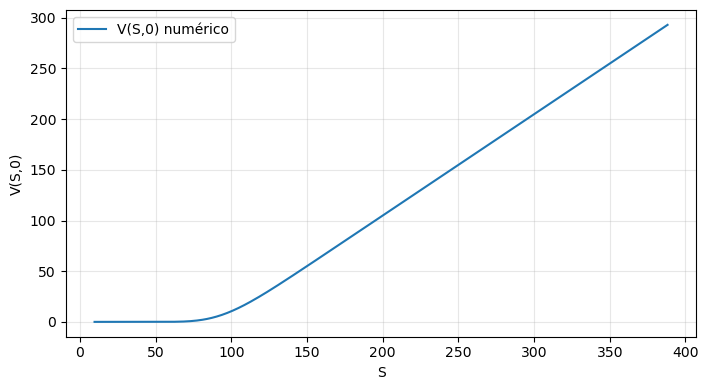

In [49]:
# %% ------------------------------------------------------------
# Retransformación V(S,t) desde la ecuación del calor
# Solo devuelve V(S,0) y la grilla S (sin gráficos)
# ------------------------------------------------------------

import numpy as np
import math

# ========= PARÁMETROS =========
K = 100.0
r = 0.05
sigma = 0.20
T = 1.0
option = 'call'     # 'call' o 'put'
scheme = 'cn'       # 'explicit' | 'implicit' | 'cn'

# Dominio
S_min_solve, S_max_solve = 0.1*K, 4.0*K
x_min, x_max = np.log(S_min_solve), np.log(S_max_solve)
Nx  = 400
dx  = (x_max - x_min)/Nx
x   = np.linspace(x_min, x_max, Nx+1)
tau_max = 0.5 * sigma**2 * T

# malla temporal
lam   = 0.45
dtau  = lam * dx**2
Nt    = int(np.ceil(tau_max / dtau))
dtau  = tau_max / Nt
lam   = dtau / dx**2
tau   = np.linspace(0.0, tau_max, Nt+1)

# ========= UTILIDADES =========
def payoff(S):
    if option == 'call':
        return np.maximum(S - K, 0.0)
    else:
        return np.maximum(K - S, 0.0)

def condicion_inicial(x_vec):
    return np.exp(-r*T) * payoff(np.exp(x_vec))

def frontera_izquierda(tau_):
    if option == 'call':
        return 0.0
    else:
        return np.exp(-r*T) * (K - np.exp(x_min + tau_))

def frontera_derecha(tau_):
    if option == 'call':
        return np.exp(-r*T) * (np.exp(x_max + tau_) - K)
    else:
        return 0.0

def bs_price(S, K, r, sigma, T, flag='call'):
    from math import log, sqrt, exp, erf
    def N(z): return 0.5*(1+erf(z/np.sqrt(2)))
    if T <= 0: return max(S-K,0) if flag=='call' else max(K-S,0)
    d1 = (log(S/K)+(r+0.5*sigma**2)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    if flag=='call':
        return S*N(d1)-K*exp(-r*T)*N(d2)
    else:
        return K*exp(-r*T)*N(-d2)-S*N(-d1)

# ========= SOLUTORES =========
def solve_explicito(x, tau, lam):
    # Esquema explícito (Forward-Time, Central-Space)
    if lam > 0.5 + 1e-12:
        raise ValueError(f"Explícito inestable: λ={lam:.4f} > 0.5")
    Nx1, Nt1 = len(x), len(tau)
    Y = np.zeros((Nt1, Nx1))
    y = condicion_inicial(x)
    Y[0, :] = y
    for n in range(Nt1 - 1):
        y_new = y.copy()
        y_new[1:-1] = y[1:-1] + lam * (y[2:] - 2.0*y[1:-1] + y[:-2])
        y_new[0]  = frontera_izquierda(tau[n+1])
        y_new[-1] = frontera_derecha(tau[n+1])
        y = y_new
        Y[n+1, :] = y
    return Y

def solve_implicito(x, tau, lam):
    Nx1, Nt1 = len(x), len(tau)
    Y = np.zeros((Nt1, Nx1))
    y = condicion_inicial(x)
    Y[0,:] = y
    Nint = Nx1-1
    main = (1 + 2*lam) * np.ones(Nint-1)
    off  = (-lam)      * np.ones(Nint-2)
    A = np.diag(main) + np.diag(off, 1) + np.diag(off, -1)
    for n in range(Nt1-1):
        yL = frontera_izquierda(tau[n+1])
        yR = frontera_derecha(tau[n+1])
        rhs = y[1:-1].copy()
        rhs[0]  += lam * yL
        rhs[-1] += lam * yR
        y_int = np.linalg.solve(A, rhs)
        y[0], y[1:-1], y[-1] = yL, y_int, yR
        Y[n+1,:] = y
    return Y

def solve_crank_nicolson(x, tau, lam):
    Nx1, Nt1 = len(x), len(tau)
    Y = np.zeros((Nt1, Nx1))
    y = condicion_inicial(x)
    Y[0,:] = y
    Nint = Nx1-1
    main_A = (1.0 + lam)  * np.ones(Nint-1)
    off_A  = (-0.5*lam)   * np.ones(Nint-2)
    A = np.diag(main_A) + np.diag(off_A, 1) + np.diag(off_A, -1)
    main_B = (1.0 - lam)  * np.ones(Nint-1)
    off_B  = ( 0.5*lam)   * np.ones(Nint-2)
    B = np.diag(main_B) + np.diag(off_B, 1) + np.diag(off_B, -1)
    for n in range(Nt1-1):
        yL_n,  yR_n  = frontera_izquierda(tau[n]),   frontera_derecha(tau[n])
        yL_np, yR_np = frontera_izquierda(tau[n+1]), frontera_derecha(tau[n+1])
        rhs = B @ y[1:-1]
        rhs[0]  += 0.5*lam*(yL_n + yL_np)
        rhs[-1] += 0.5*lam*(yR_n + yR_np)
        y_int = np.linalg.solve(A, rhs)
        y[0], y[1:-1], y[-1] = yL_np, y_int, yR_np
        Y[n+1,:] = y
    return Y

# ========= ELEGIR ESQUEMA Y RESOLVER =========
if scheme == 'explicit':
    Y = solve_explicito(x, tau, lam)
elif scheme == 'implicit':
    Y = solve_implicito(x, tau, lam)
elif scheme in ('cn', 'crank', 'crank-nicolson'):
    Y = solve_crank_nicolson(x, tau, lam)
else:
    raise ValueError("scheme debe ser 'explicit', 'implicit' o 'cn'")

# ========= RETRANSFORMACIÓN (solo V(S,0)) =========
# 1) Grilla S y factor de retransformación
tau_final = tau[-1]
S_grid = np.exp(x - ((2*r/sigma**2) - 1.0)*tau_final)
factor = np.exp(r*(T - 2*tau_final/sigma**2))

# 2) Recuperar V(S,0)
V_S0 = factor * Y[-1,:]

# ========= SALIDA =========
# Ordenamos por S ascendente y devolvemos ambos vectores
order = np.argsort(S_grid)
S_sorted = S_grid[order]
V_sorted = V_S0[order]

print(f"\n--- Resultado final (esquema = {scheme}) ---")
print(f"Longitud grilla: {len(S_sorted)} puntos.")
print(f"Precio numérico en S0={K}, t=0 ≈ "
      f"{np.interp(K, S_sorted, V_sorted):.6f}")
print("\nPrimeros 10 pares (S, V(S,0)):")
for i in range(0, len(S_sorted), len(S_sorted)//10):
    print(f"S={S_sorted[i]:8.3f}  V={V_sorted[i]:10.6f}")

# devuelve también los arrays (útil en notebooks)
S_sorted, V_sorted

# --- GRAFICAR SOLO LA CURVA V(S,0) ---
import matplotlib.pyplot as plt

plt.figure(figsize=(7.2,4.0))
plt.plot(S_sorted, V_sorted, label='V(S,0) numérico')
plt.xlabel('S')
plt.ylabel('V(S,0)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



# Ejercicio 3

i) Gráficos de la superficie V(S,t)

In [50]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # fuerza backend 3D

# --- Black–Scholes cerrado ---
from math import log, sqrt, exp
from scipy.stats import norm

def bs_price_np(S, K, r, sigma, T, flag='call'):
    S = np.asarray(S, dtype=float)

    # Caso trivial T=0
    if T <= 0:
        if flag == 'call':
            return np.maximum(S - K, 0)
        else:
            return np.maximum(K - S, 0)

    # Usamos math.erf pero vectorizado
    erf_vec = np.vectorize(math.erf)

    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    N = lambda z: 0.5 * (1 + erf_vec(z / np.sqrt(2)))

    if flag == 'call':
        return S*N(d1) - K*np.exp(-r*T)*N(d2)
    else:
        return K*np.exp(-r*T)*N(-d2) - S*N(-d1)

# --- Mapeo x -> S a cada tau (acorde a tu cambio de variables) ---
def shift_tau(r, sigma, tau):
    # tau puede ser escalar o array
    return (2.0*r/sigma**2 - 1.0) * tau

def S_from_x_tau(x, r, sigma, tau):
    # x (Nx,) y tau (Nt,) => devuelve (Nt, Nx) con S(tau_j, x_i) = exp(x_i - shift(tau_j))
    x = np.asarray(x)
    tau = np.asarray(tau)
    sh = shift_tau(r, sigma, tau)[:, None]   # (Nt,1)
    return np.exp(x[None,:] - sh)            # (Nt, Nx)


In [51]:
def plot_superficie_y_slices(V_metodo, x, tau, r, sigma, titulo='Método'):
    """
    V_metodo: array (Nt+1, Nx) con V(x, tau_j) en cada fila (tau aumenta de 0 -> tau_max)
    x:        array (Nx,)
    tau:      array (Nt+1,) creciente, con tau[-1] = tau_max  (t=0)
    """
    V_metodo = np.asarray(V_metodo)
    Nt1, Nx = V_metodo.shape

    # Construyo S-grid dependiente de tau: S_j,i = exp(x_i - shift(tau_j))
    S_mat = S_from_x_tau(x, r, sigma, tau)     # (Nt+1, Nx)

    # Grafico superficie 3D (S,t) -> V
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    # Convertimos tau a tiempo físico: t = T - 2*tau/sigma^2  (si querés en t, pasás T)
    # Si sólo querés etiquetar por tau, usamos tau. Acá uso tau en eje Y.
    TT, SS = np.meshgrid(tau, x, indexing='ij')  # sólo para shape
    ax.plot_surface(S_mat, TT, V_metodo, linewidth=0, antialiased=True, alpha=0.9)
    ax.set_xlabel('S')
    ax.set_ylabel('tau')
    ax.set_zlabel('V')
    ax.set_title(f'{titulo}: Superficie V(S, tau)')
    plt.tight_layout()
    plt.show()

    # 6 curvas a tiempos equiespaciados (en tau)
    idxs = np.linspace(0, Nt1-1, 6, dtype=int)
    plt.figure(figsize=(8,5))
    for j in idxs:
        Sj = S_mat[j,:]
        Vj = V_metodo[j,:]
        # Ordeno por S por si la malla en S no es estrictamente creciente
        order = np.argsort(Sj)
        plt.plot(Sj[order], Vj[order], label=f'tau={tau[j]:.3f}')
    plt.xlabel('S')
    plt.ylabel('V(S, tau_j)')
    plt.title(f'{titulo}: 6 cortes temporales')
    plt.legend()
    plt.tight_layout()
    plt.show()


Graficamos para cada método:

&nbsp; &nbsp; &nbsp; &nbsp; - Superficie en un plano 3D

&nbsp; &nbsp; &nbsp; &nbsp; - 6 curvas con cortes temporales distintos y equiespaciados


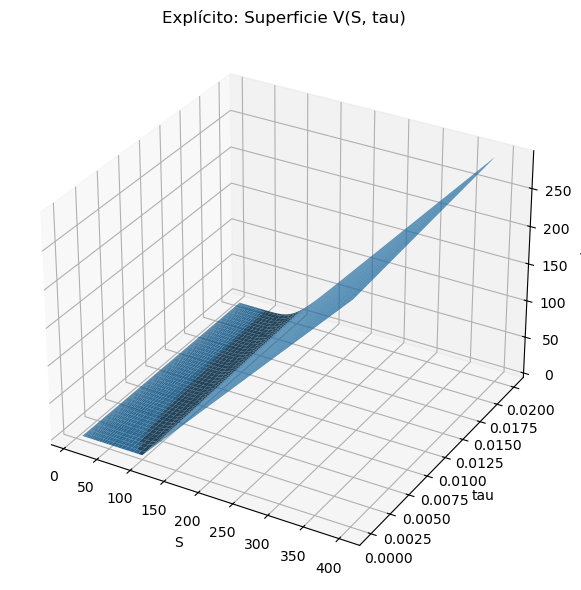

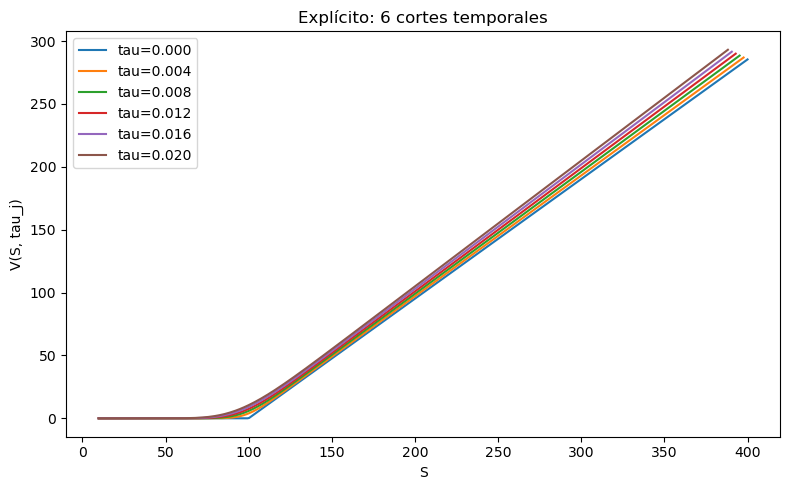

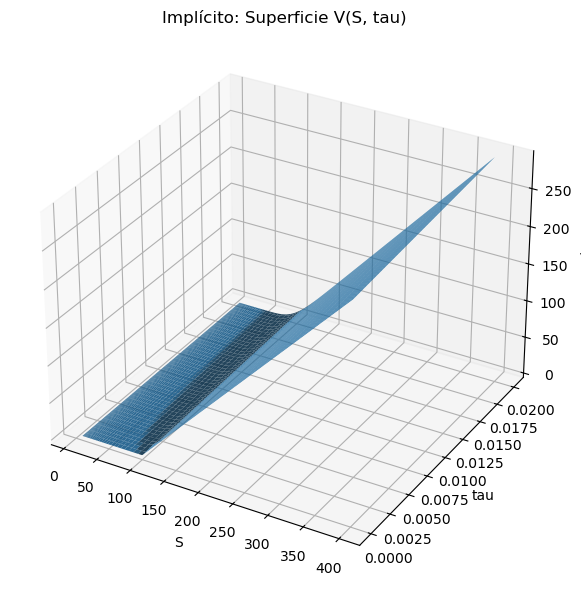

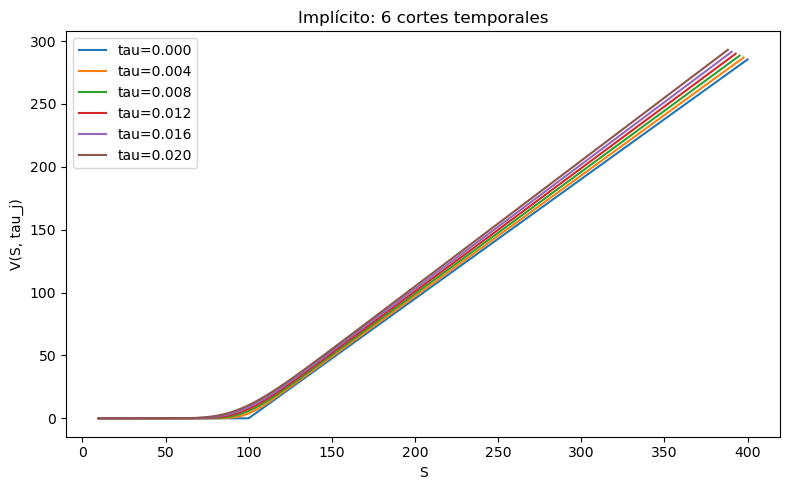

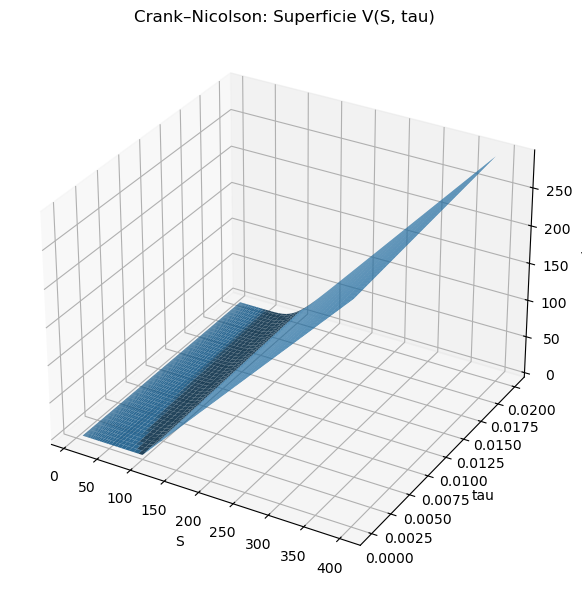

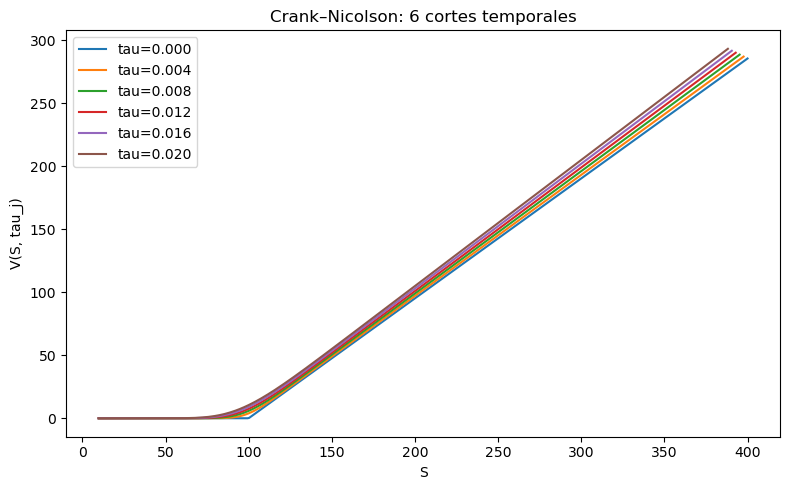

In [52]:
Y_exp = solve_explicito(x, tau, lam)
Y_imp = solve_implicito(x, tau, lam)
Y_cn  = solve_crank_nicolson(x, tau, lam)

plot_superficie_y_slices(Y_exp, x, tau, r, sigma, titulo='Explícito')
plot_superficie_y_slices(Y_imp, x, tau, r, sigma, titulo='Implícito')
plot_superficie_y_slices(Y_cn,  x, tau, r, sigma, titulo='Crank–Nicolson')

ii) Ahora llevamos a cabo la compraracion gráfica de cada método contra BS mediante el error relativo.

In [53]:
def plot_error_relativo_t0(V_metodo, x, tau, r, sigma, K, T, tipo='call', titulo='Método'):
    """
    Dibuja error relativo = |V_num - V_BS| / max(|V_BS|, eps) en t=0 (tau_max).
    Espera V_metodo como matriz 2D: shape = (Nt+1, Nx) con la solución en toda la grilla (τ,x).
    """
    V_metodo = np.asarray(V_metodo)
    Nt1, Nx = V_metodo.shape  # asegura 2D

    tau_max = tau[-1]
    # S en t=0:
    shift = (2.0*r/sigma**2 - 1.0) * tau_max
    S_t0 = np.exp(x - shift)                    # (Nx,)

    V_num_t0 = V_metodo[-1, :]                  # última fila = t=0
    V_bs_t0  = bs_price_np(S_t0, K, r, sigma, T, flag=tipo)

    eps = 1e-14
    err_rel = np.abs(V_num_t0 - V_bs_t0) / np.maximum(np.abs(V_bs_t0), eps)

    order = np.argsort(S_t0)
    plt.figure(figsize=(8,5))
    plt.plot(S_t0[order], err_rel[order])
    plt.xlabel('S')
    plt.ylabel('Error relativo')
    plt.title(f'{titulo} vs Black–Scholes en t=0 ({tipo})')
    plt.tight_layout()
    plt.show()



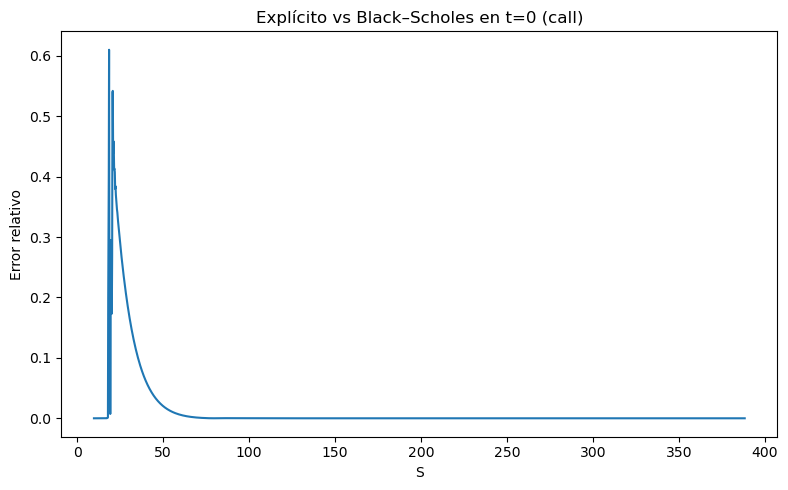

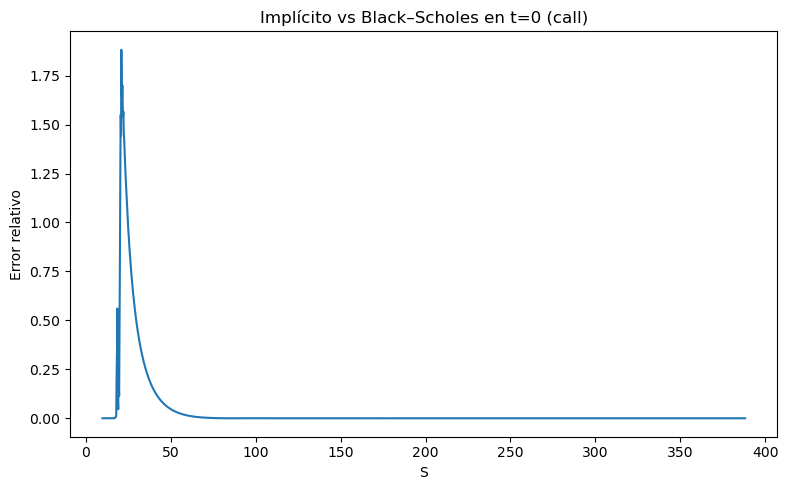

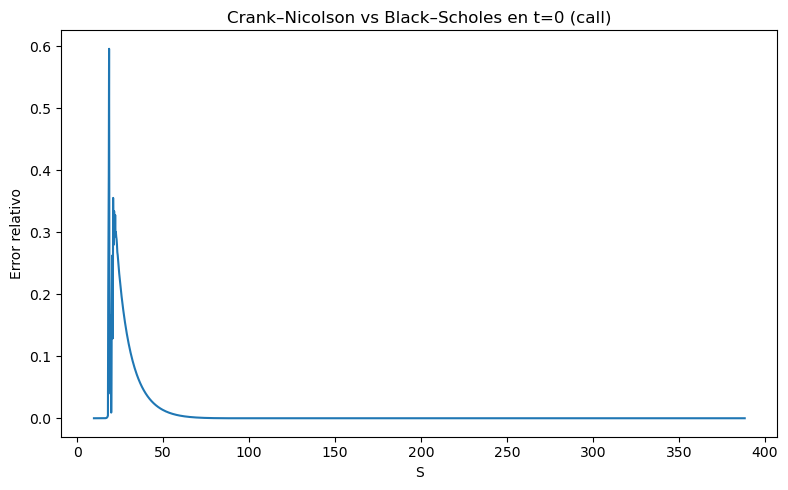

In [54]:
tipo = 'call'  # o 'put'

Y_exp = solve_explicito(x, tau, lam)
Y_imp = solve_implicito(x, tau, lam)
Y_cn  = solve_crank_nicolson(x, tau, lam)

plot_error_relativo_t0(Y_exp, x, tau, r, sigma, K, T, titulo='Explícito')
plot_error_relativo_t0(Y_imp, x, tau, r, sigma, K, T, titulo='Implícito')
plot_error_relativo_t0(Y_cn,  x, tau, r, sigma, K, T,titulo='Crank–Nicolson')


Para el caso graficado (Call), una vez que expresamos el error relativo en función de S, y vamos incrementando esta variable, vemos que en los primeros incrementos dispara fuertemente el error relativo, mientras que luego el error experimenta una convergenacia a cero en los tres casos. El salto inicial en el error relativo es similar en la comparación Exp-BS y CN-BS, con este último alcanzando un error relativo máximo apenas menor que el de Exp-BS. Por su parte, el pico del error relativo entre Imp-BS es de casi el triple en comparación con el de los otros dos métodos.

En la comparación de CN-BS se ve una corrección mas bien rápida, dado que una vez alcanzado el pico de error, el siguiente gran pico ocurre a casi la mitad de error relativo. En el caso del explícito, si bien su error no se dispara a los niveles vistos en el implícito, experimenta una corrección mas lenta en los primeros pasos, dado que los picos que le siguen al error máximo son más cercanos a este máximo en comparación con los de CN. Algo parecido sucede con el implícito, y dado que el error máximo es de casi el triple que los demás gráficos, relativamente a esto experimenta una corrección que se hace notar. Ya para S = 50 la convergencia a cero está prácticamente consolidada en los tres casos.

# Ejercicio 4

La idea acá es mostrar la variación en el error absoluto entre los métodos y BS a medida que vamos alterando la malla, tanto en $\Delta x$ como en $\Delta \tau$.

Vamos a suponer que la opció está ATM (K=S=100)

In [55]:
# Convergencia en ATM (S0 = K)
import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt, exp, erf

#Black–Scholes
def N(z):
    #Función de distribución normal estándar
    return 0.5 * (1.0 + erf(z / sqrt(2.0)))

def BlackScholes_Pricing(S, K, r, sigma, T, tipo='call'):
    """
    Precio Black–Scholes para opción europea.
    tipo = 'call' o 'put'
    """
    if T <= 0:
        return max(S-K, 0.0) if tipo == 'call' else max(K-S, 0.0)

    d1 = (log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)

    if tipo == 'call':
        return S * N(d1) - K * exp(-r*T) * N(d2)
    else:
        return K * exp(-r*T) * N(-d2) - S * N(-d1)

# Grilla en x, tau a partir de Nx y lambda
def build_grid_from_lambda(Nx, lam_target, K, r, sigma, T):
    """
    Construye x, tau para un Nx dado y un target de lambda,
    y devuelve x, tau, dx, dtau, lam_efectivo, Nt
    """
    S_min, S_max = 0.1*K, 4.0*K
    x_min, x_max = np.log(S_min), np.log(S_max)

    dx = (x_max - x_min) / Nx
    x  = np.linspace(x_min, x_max, Nx+1)

    tau_max = 0.5 * sigma**2 * T
    dtau    = lam_target * dx**2
    Nt      = int(np.ceil(tau_max / dtau))
    dtau    = tau_max / Nt
    lam_eff = dtau / dx**2
    tau     = np.linspace(0.0, tau_max, Nt+1)

    return x, tau, dx, dtau, lam_eff, Nt

#Ejecutar un esquema del Ej 1
def run_scheme_once(Nx, lam_target, scheme, K, r, sigma, T, option='call'):
    """
    Corre los métodos del EJ 1:
      - precio_explicito
      - precio_implicito
      - precio_crank_nicolson

    Usa payoff_descontado, frontera_izquierda y frontera_derecha
    también definidos en el Ej 1.

    Devuelve:
      V_S0 (precio numérico en S0=K), dx, dtau, lam_eff, Nt
    """
    # 1) Grilla
    x, tau, dx, dtau, lam_eff, Nt = build_grid_from_lambda(
        Nx, lam_target, K, r, sigma, T)

    #Payoff inicial en variable transformada
    y0 = payoff_descontado(x, K, r, T, tipo=option).copy()
    S0 = K  # ATM

    #Selección de esquema
    scheme = scheme.lower()

    if scheme == 'explicit':
        #estabilidad del explícito
        if lam_eff > 0.5 + 1e-12:
            raise ValueError(f"Explícito inestable: λ={lam_eff:.4f} > 0.5")

        """
        precio_explicito(S0, K, r, sigma, T, x, tau, lam, Nt, y, frontera_izquierda, frontera_derecha)
        """
        V_S0, Y = precio_explicito(
            S0, K, r, sigma, T,
            x, tau, lam_eff, Nt, y0,
            frontera_izquierda, frontera_derecha)

    elif scheme == 'implicit':
        """
        precio_implicito(y0, lam, Nt, frontera_izquierda, frontera_derecha,
        tau, Nx, r, sigma, T, x, S0)
        """
        V_S0, Y = precio_implicito(
            y0, lam_eff, Nt,
            frontera_izquierda, frontera_derecha,
            tau, Nx, r, sigma, T, x, S0)

    elif scheme in ['crank nicolson', 'crank-nicolson', 'cn', 'crank']:
        tau_max = tau[-1]
        """
        precio_crank_nicolson(y0, lam, N, Nt, frontera_izquierda, frontera_derecha,
        tau, r, sigma, tau_max, x, K, S0)
        """
        V_S0, Y = precio_crank_nicolson(
            y0, lam_eff, Nx, Nt,
            frontera_izquierda, frontera_derecha,
            tau, r, sigma, tau_max, x, K, S0)

    else:
        raise ValueError("scheme debe ser 'explicit', 'implicit' o 'crank nicolson'")

    return float(V_S0), dx, dtau, lam_eff, Nt


# Funcion de convergencia
def convergencia(K=100.0, r=0.05, sigma=0.20, T=1.0, option='call'):
    """
    Muestra cómo cambia el error |V_Δ - V_BS| al refinar Δx y Δτ,
    suponiendo ATM (S0 = K).

    Usa exclusivamente:
      - precio_explicito (Ej 1)
      - precio_implicito (Ej 1)
      - precio_crank_nicolson (Ej 1)
      - BlackScholes_Pricing (Ej 2)
    """
    S0 = K  # ATM

    # Valor de Black–Scholes en t=0
    V_BS_ATM = BlackScholes_Pricing(S0, K, r, sigma, T, option)
    print(f"Valor BS ATM (S0=K={K}): {V_BS_ATM:.6f}")

    # Convergencia espacial
    NX_LIST_SPATIAL = [40, 80, 160, 320, 640] #Hacer una lista con mas valores para ver mas puntos en el grafico
    LAM_SPATIAL     = 0.45   #lambda "bueno" para la estabilidad (del explícito)

    schemes = ['explicit', 'implicit', 'cn']
    nombres = {
        'explicit': 'Explícito',
        'implicit': 'Implícito',
        'cn':       'Crank–Nicolson'
    }

    plt.figure(figsize=(7,4))
    for sch in schemes:
        dxs  = []
        errs = []
        print(f"\nConvergencia espacial – método {nombres[sch]} (λ objetivo ≈ {LAM_SPATIAL})")
        print("Nx   dx         dtau       λ_eff     Nt    V_num_ATM    V_BS_ATM    |error|")

        for Nx in NX_LIST_SPATIAL:
            V_num, dx, dtau, lam_eff, Nt = run_scheme_once(
                Nx, LAM_SPATIAL, sch, K, r, sigma, T, option
            )
            err = abs(V_num - V_BS_ATM)
            dxs.append(dx)
            errs.append(err)
            print(f"{Nx:3d}  {dx:9.6f}  {dtau:9.6f}  {lam_eff:7.4f}  {Nt:4d}  "
                  f"{V_num:11.6f}  {V_BS_ATM:11.6f}  {err:10.6e}")

        dxs  = np.array(dxs)
        errs = np.array(errs)
        plt.plot(dxs, errs, 'o-', label=nombres[sch])

    plt.xlabel("dx")
    plt.ylabel(r"|V_\Delta(K,0) - V_{BS}(K,0)|")
    plt.title("Convergencia espacial ATM")
    plt.grid(True, alpha=0.3)
    plt.gca().invert_xaxis()  #Al refinar dx vamos hacia la derecha
    plt.legend()
    plt.tight_layout()
    plt.show()

    #Convergencia temporal
    
    NX_FIXED_TEMP = 320
    LAM_LIST_TEMP = [0.45, 0.30, 0.20, 0.15, 0.10]

    plt.figure(figsize=(7,4))
    for sch in schemes:
        dtaus = []
        errs  = []
        print(f"\nConvergencia temporal – método {nombres[sch]} (Nx fijo = {NX_FIXED_TEMP})")
        print("λ_eff     dtau       dx         Nt    V_num_ATM    V_BS_ATM    |error|")

        for lam_try in LAM_LIST_TEMP:
            #Para explícito respetamos lambda <= 0.5
            if sch == 'explicit' and lam_try > 0.5:
                continue

            V_num, dx, dtau, lam_eff, Nt = run_scheme_once(
                NX_FIXED_TEMP, lam_try, sch, K, r, sigma, T, option
            )
            err = abs(V_num - V_BS_ATM)
            dtaus.append(dtau)
            errs.append(err)
            print(f"{lam_eff:7.4f}  {dtau:9.6f}  {dx:9.6f}  {Nt:4d}  "
                  f"{V_num:11.6f}  {V_BS_ATM:11.6f}  {err:10.6e}")

        dtaus = np.array(dtaus)
        errs  = np.array(errs)
        plt.plot(dtaus, errs, 'o-', label=nombres[sch])

    plt.xlabel("dtau")
    plt.ylabel(r"|V_\Delta(K,0) - V_{BS}(K,0)|")
    plt.title("Convergencia temporal ATM")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

Valor BS ATM (S0=K=100): 10.450584

Convergencia espacial – método Explícito (λ objetivo ≈ 0.45)
Nx   dx         dtau       λ_eff     Nt    V_num_ATM    V_BS_ATM    |error|
 40   0.092222   0.003333   0.3919     6     8.792956    10.450584  1.657627e+00
 80   0.046111   0.000952   0.4479    21    11.715627    10.450584  1.265043e+00
160   0.023055   0.000238   0.4479    84    10.203091    10.450584  2.474926e-01
320   0.011528   0.000060   0.4493   335    10.201107    10.450584  2.494770e-01
640   0.005764   0.000015   0.4499  1338    10.565269    10.450584  1.146853e-01

Convergencia espacial – método Implícito (λ objetivo ≈ 0.45)
Nx   dx         dtau       λ_eff     Nt    V_num_ATM    V_BS_ATM    |error|
 40   0.092222   0.003333   0.3919     6     8.471859    10.450584  1.978725e+00
 80   0.046111   0.000952   0.4479    21    11.633203    10.450584  1.182619e+00
160   0.023055   0.000238   0.4479    84    10.181624    10.450584  2.689594e-01
320   0.011528   0.000060   0.4493   335 

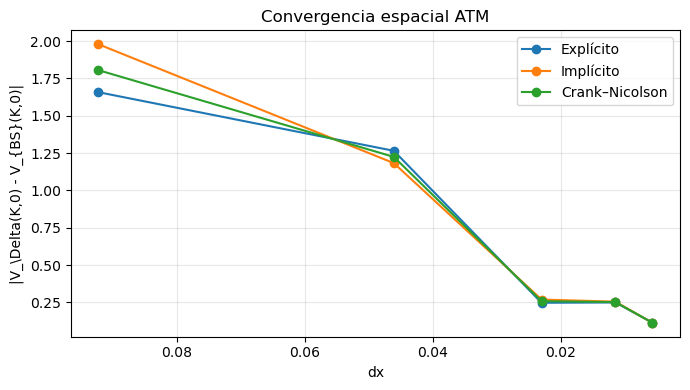


Convergencia temporal – método Explícito (Nx fijo = 320)
λ_eff     dtau       dx         Nt    V_num_ATM    V_BS_ATM    |error|
 0.4493   0.000060   0.011528   335    10.201107    10.450584  2.494770e-01
 0.2998   0.000040   0.011528   502    10.200213    10.450584  2.503705e-01
 0.1999   0.000027   0.011528   753    10.199616    10.450584  2.509678e-01
 0.1499   0.000020   0.011528  1004    10.199317    10.450584  2.512664e-01
 0.0999   0.000013   0.011528  1506    10.199018    10.450584  2.515651e-01

Convergencia temporal – método Implícito (Nx fijo = 320)
λ_eff     dtau       dx         Nt    V_num_ATM    V_BS_ATM    |error|
 0.4493   0.000060   0.011528   335    10.195737    10.450584  2.548464e-01
 0.2998   0.000040   0.011528   502    10.196630    10.450584  2.539536e-01
 0.1999   0.000027   0.011528   753    10.197227    10.450584  2.533566e-01
 0.1499   0.000020   0.011528  1004    10.197526    10.450584  2.530580e-01
 0.0999   0.000013   0.011528  1506    10.197824    10.450

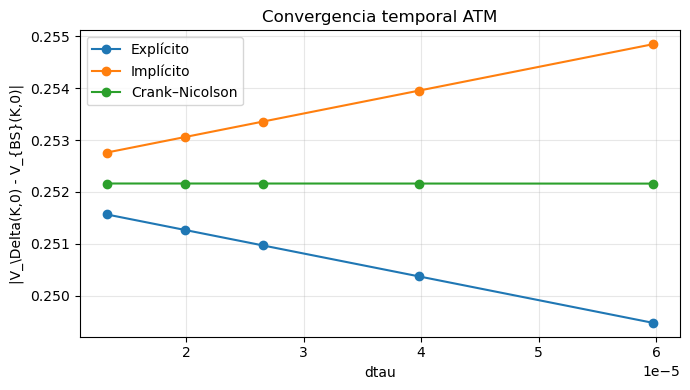

In [56]:
#Zona de llamadas y ejecucion de las funciones definias en el box anterior
K = 100
r = .05
sigma = .2 
T = 1
option_type = "call"
convergencia(K, r, sigma, T, option_type)

**Nota:** 

La lista Nx_LIST_SPATIAL y LAM_LIST_TEMP controla los Nx, y lam_eff (y dtau en consecuencia) respectivamente de las tablas y gráficos 
que se imprimen abajo. Los valores elegidos pueden hacer que tarde bastante en correr el código más que nada en los métodos implícito 
y CN, por lo tanto sugerimos no modificar la lista con valores más altos sin antes probar cuánto tarda en correr el código con los valores
 que ya están.
 
Valores altos en la primer lista y bajos en la segunda hacen que en los gráficos podamos ver una mayor convergencia (poque disminuye
la discretización), pero incrementa sustancialmente el costo y tiempo de correr los métodos una y otra vez para esos valores.  
Logicamente, si el error va descendiendo, si la discretización es menor, deberíamos pensar que el error va a ser aún menor, pero debido
a lo costoso que se puede volver trabajar estos métodos con niveles mucho mas finos de discretización, consideramos que de todas formas
los gráficos ilustran bien lo pedido en la consigna.

**En relación con los resultados obtenidos:**

Para el caso de $\Delta x$, vemos como en los tres casos, afinar la malla que discretiza el dominio hace que el error respecto al valor del option calculado por Black Scholes sea menor. El método explícito responde rápido aún cuando la discretización sea cada vez más fina, aunque trae los problemas de inestabilidad si $\lambda$ < 0.5. Si bien el implícito y CN no tienen esta condición para permanecer estables, se vuelven demasiado costosos a medida que nos interesa ver qué sucede con el error si afinamos la malla, y el gráfico no muestra que el error del explícito quede muy por encima de los otros dos métodos a medida que afinamos la malla, con lo cual nos convoca reflexionar si priorizamos un poco más de precisión a cambio de un costo sustancialmente mayor o no.

Para el caso de $\Delta \tau$, notamos en primer lugar que el costo y tiempo de ejecución se volvía notablemente mayor que en el caso de $\Delta x$. En cuanto al comportamiento de los errores a medida que se afinaba la malla, los tres métodos parten de puntos completamente distintos y van convergiendo.

El gráfico se lee de esta manera:

&nbsp; &nbsp; &nbsp; &nbsp; - Nos movemos de derecha a izquierda. A la derecha tenemos una malla mas gruesa, y a izquierda se va afinando la malla.

Ahora que ya sabemos cómo leer el gráfico, podemos decir que el método implícito fue disminuyendo su error, CN mantuvo estabilidad en términos de error, y el explícito pasó de menos a más, pero los tres parecen converger a un error parecido. Como mencionamos anteriormente, no experimentamos esta convergencia en el gráfico dado que ello implica discretizar el dominio de una forma tal que el costo de correr el método implícito y CN se vuelve inviable, y por lo tanto debemos conformarnos con creer que esta tendencia de convergencia continúa.
